In [1]:
import pandas as pd
import numpy as np
import csv
import unittest
import matplotlib.pyplot as plt
import math
from dateutil import parser
import re

# Tolerance formula

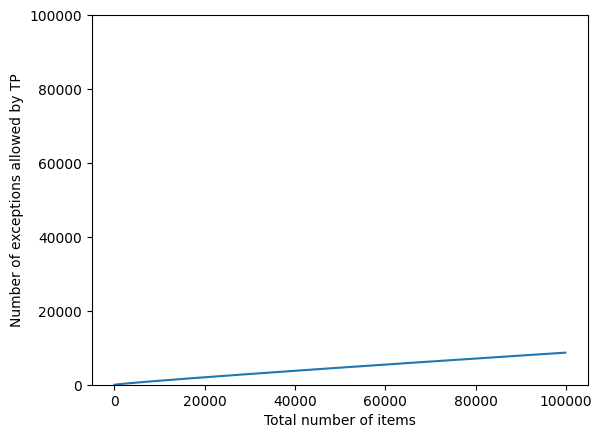

In [2]:
def tolerance_formula(N, e):
    '''
    Tolerance formula from Yang, p. 9
    '''
    print(N, e)
    return e <= N/np.log(N)

def tolerance_formula_plot(N):
    '''
    Tolerance formula from Yang, p. 9
    '''
    return N/np.log(N)

def plot_tolerance():
    tot = 100000
    N = np.arange(2,tot,100)
    plt.plot(N, tolerance_formula_plot(N))
    plt.ylim(0, tot)
    plt.xlabel("Total number of items")
    plt.ylabel("Number of exceptions allowed by TP")
    plt.show()

plot_tolerance()

# Data file operations
This part of the code deals with file operations, such as reading and closing files

## Preferably use the final function for saving!
Older ones are kind of deprecated

In [3]:
def save_data(filename, df):
    """
    Code from: https://www.kite.com/python/answers/how-to-save-a-pandas-dataframe-in-python
    """
    df.to_pickle(filename)


def read_data(filename):
    """
    Code from: https://www.kite.com/python/answers/how-to-save-a-pandas-dataframe-in-python
    """
    return pd.read_pickle(filename)

In [4]:
def append_representation_to_dataframe(df):
    '''
    Appends the syllable representations of the model and realization to the dataframe 
    to have all information in one place
    
    df: data set, of which the representations need to be appended
    
    No return, as it mutates the df object
    '''
    df['rep_model'] = df.model.apply(build_syllable_representation)
    df['rep_realization'] = df.realization.apply(build_syllable_representation)
    #print(df)

In [5]:
def filter_df(df):
    '''
    Filters words ending in @n from the data set as they complicate things
    
    df: the data set that needs to be filter
    
    return: the filtered dataset
    '''
    return df[df.model.apply(lambda x: not (x[-1] == 'n' and x[-2] == 'ə'))]
    

In [6]:
def write_nonmatches_to_csv(filename, df, comparison, header = ['Name', 'Age', 'word', 'model','realization','stressmodel','stressrealization'], apply_filter=True):
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        for n, a, word, w,v in collect_nonmatches_metadata(df, comparison):
            if not apply_filter:
                writer.writerow([n,a,word,w, v, build_syllable_representation(w), build_syllable_representation(v)])
            else:
                rep_w = build_syllable_representation(w)
                rep_v = build_syllable_representation(v)
                # If at least one of the two representations has 2 or more syllables, then we are interested
                if len(rep_w) >= 2 or len(rep_v) >= 2: 
                    writer.writerow([n,a,word,w, v, rep_w, rep_v])

In [7]:
def write_stats_to_csv(filename, a,b,c,d,e):
    '''
    stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act
    '''
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(['number','modellengthall','realizationlengthall','lengthmatch', 'modellengthnonmatch', 'realizationlengthnonmatch'])

        # write the data
        for i in range(10):
            writer.writerow([i, a[i], b[i], c[i], d[i], e[i]])

In [8]:
def write_df_to_csv(filename, df):
    df.to_csv(filename)

# Word class

In [9]:
class Word:
    def __init__(self, written, model, realization, rep_model, rep_realization):
        self.written = written
        self.model = model
        self.realization = realization
        self.rep_model = rep_model
        self.rep_realization = rep_realization
    
    def __eq__(self, other):
        return self.written == other.written
    
    def __hash__(self):
        return self.written.__hash__()

    def is_bisyl(self):
        return len(self.rep_model) == 2
    
    def is_iambic_bisyl(self):
        if len(self.rep_model) == 2:
            return self.rep_model[1]
        else:
            return False 
    
    def is_final_syllable_heavy(self):
        if self.model[-1] in ipa_vowels:
            # if the last letter is a vowel, we only have a heavy syllable if it is a diphtong, so if the letter before it is also a vowel
            return self.model[-2] in ipa_vowels
        else: #so final letter in agnostic_symbols or consonants
            return True
    
    def is_final_syllable_superheavy(self):
        '''
        if final is vowel, then check if prefinal is also vowel (or in agnostic and then the one before)
        if final is consonant, then check if prefinal is consonant. 
            If consonant, then superheavy
            If agnostic, check the one before and repeat
            If vowel, check the one before; if vowel again, then superheavy. If agnostic, check the one before. If consonant, not superheavy
        '''

        old_word = self.model
        word = ""

        for i in range(0,len(old_word)):
            if old_word[i] == 'ː':
                if old_word[i-1] in ipa_vowels:
                    word += 'a'
                else: 
                    word += 'c'
            else:
                word += old_word[i]

        word = [c for c in word if (c not in agnostic_symbols) and c != 'ˈ' and c != 'ˌ']

        if len(word) < 3:
            return False

        if word[-1] in ipa_vowels:
            return False
        else: #last char is a consonant
            if word[-2] not in ipa_vowels:
                # two consonants
                return True
            else:
                if word[-3] in ipa_vowels:
                    return True
                else:
                    return False

    
    def matches_pattern(self, pattern, model = True):
        '''
        Calculates whether the word matches the stress pattern. Pattern characters:
            T: stressed syllable
            F: unstressed syllable
            @: syllable ending in schwa
            +: concatenates two possible patterns; function will return true if either matches
            H: heavy and stressed syllable
            h: heavy and unstressed syllable
            N: nonheavy and stressed syllable
            n: nonheavy and unstressed syllable
        
        pattern: string of F(alse) and T(rue) or A(gnostic) indicating the stress placement
        model: boolean which indicates whether to match to the model representation (True) or realization representation (False)
        Agnostic (or any other symbol) can be used to indicate that one does not care about the stress placement
        
        return: 
        '''
        if model:
            word = self.rep_model
        else:
            word = self.rep_realization
        
        
        # First part is for plusses in the string (e.g. 'AA+AAA') (which recursively checks for the different parts)
        if '+' in pattern:
            parts = pattern.split('+')
            return any([self.matches_pattern(part, model=model) for part in parts])
        
        # Second part is for normal strings without plusses
        
        
        # Initial check for length match. If not equal, no point in persuing (and prevents out of bound errors later on)
        if len(pattern) != len(word):
            return False
        
        for i,c in enumerate(pattern):
            if c == 'T':
                if not word[i]:
                    return False
            if c == 'F': 
                if word[i] or ((self.realization[-1] == 'ə') and i == len(pattern)-1): # we want to exclude the schwa ending words here
                    return False
            if c == '@':
                if not (self.realization[-1] == 'ə'):
                    return False
            if c == 'H':
                if not word[i] or not self.is_final_syllable_superheavy():
                    return False
            if c == 'h':
                if word[i] or not self.is_final_syllable_superheavy():
                    return False
            if c == 'N':
                if not word[i] or self.is_final_syllable_superheavy():
                    return False
            if c == 'n':
                if word[i] or self.is_final_syllable_superheavy():
                    return False
        return True
    

#test_word = Word('test', 'testə', 'testə', [True], [True, False])
#test_word.matches_pattern('TN', model = False)


# Wordlist class

In [10]:
class WordList:
    
    def __init__(self, time ):
        '''
        time: the point in time to which this wordlist refers
        '''
        pass
        #self.time = time
        #self.wordlist
        
    def __cmp__(self, other):
        return cmp(self.age, other.age)
    
    def __lt__(self, other):
        return self.age < other.age
    
    def __repr__(self):
        return "%s with length %s" % (self.age, len(self.wordlist))
    
    def add_word(self, word):
        pass

    def add_prev_state_wordlist(prev_wordlist):
        for word in prev_wordlist.wordlist:
            self.add_word(word)
    
    def parse_age(self):
        numbers = re.findall('\d+', self.time)
        # the age in months with a approximation for the number of days
        return float(numbers[0])*12 + float(numbers[1]) + float(numbers[2])/31.0

def leng(wordlist):
    return len(wordlist.wordlist)

In [11]:
class UniqueWordList(WordList):
    
    def __init__(self, time ):
        '''
        time: the point in time to which this wordlist refers
        '''
        self.time = time
        self.age = self.parse_age()
        self.wordlist = set()
    
    def add_word(self, word):
        self.wordlist.add(word)

In [12]:
class AllWordList(WordList):
    
    def __init__(self, time ):
        '''
        time: the point in time to which this wordlist refers
        '''
        self.time = time
        self.age = self.parse_age()
        self.wordlist = []    
    
    def add_word(self, word):
        self.wordlist.append(word)


# Child development class

In [13]:
class DevelopmentCounts:
    '''Class not in use yet!
    
    Might be useful later!
    '''
    
    def __init__(self, patterns, length):
        #iamb_bisyl_phases = 
        #patterns = {'FT': ['T', 'TF', 'TT', 'FT', 'AA']}
        
        # Goal structure:
        # dictionary:
        # { 'FT' :  ([], {'T': [], 'TF': [] } ),
        #   'TF' :  ([], {'T': [], 'TF': [] } )
        # }
        
        self.patterns
        
        self.counts = {}
        
        for p in self.patterns:
            self.counts[p] = PatternDevCounts(p, self.patterns[p], length)
            
        
    def count(self, word):
        for p in self.patterns:
            # loop through the patterns and count how many of those occurred in the data set
            # Then count how many of them had the real_pattern as well
                    
            if word.matches_pattern(p):
                self.counts[p][0][j] += 1
                for real_pat in patterns[p]:
                    if word.matches_pattern(real_pat, model = False): # If realizations matches the corresponding real pattern
                        counts[p][1][real_pat][j] += 1
        
class PatternDevCounts:
    
    def __init___(self, model_pattern, real_patterns, length):
        self.model_pattern = model_pattern
        self.real_patterns = real_patterns
        
        self.mod_counts = np.zeros(length)
        self.counts = {}
        for rp in patterns[p]:
            self.counts[rp] = np.zeros(length)

In [14]:
class ChildDevelopment:
    
    def __init__(self, name):
        '''
        name: child's name (just for bookkeeping purposes)
        '''
        self.name = name
        self.wordlists = []
        self.complete_wordlists = []
    
    
    def add_wordlist(self, wordlist, complete = False):
        '''
        Appends wordlist to the wordlists of the child
        
        wordlist: the wordlist to be added
        '''
        if not complete:
            self.wordlists.append(wordlist)
        else: 
            self.complete_wordlists.append(wordlist)

    def collect_ages(self):
        '''
        Collects all the ages of the different wordlists and saves in ages attribute
        '''
        self.ages = []
        for wordlist in self.complete_wordlists:
            self.ages.append(wordlist.age)
        
    def calculate_total_vocab_dev(self):
        '''
        Calculates the development of the vocabulary size, i.e. how the vocabulary grows through time
        
        returns: list of cumulative vocabulary sizes
        
        Todo: Add something similar for the dates so that we have those
        '''
        #print(self.wordlists[0])
        development = []
        total_wordlist = set()
        for wordlist in self.wordlists:
            
            for word in wordlist.wordlist:
                total_wordlist.add(word)
            development.append(len(total_wordlist))
        return development

    
    def calculate_development_by_patterns(self, patterns):
        '''
        Calculates the wordlists for a list of patterns and the total development
        For efficiency, this is done at once (building wordlists is expensive)
        
        patterns: the patterns one wants the developments of
        return: list of developments for the patterns
        '''
        developments_counts = {}
        developments = {}
        
        for p in patterns:
            developments[p] = set()
            developments_counts[p] = []
        
        
        for wordlist in self.wordlists:
            for word in wordlist.wordlist:
                for p in patterns:
                    if word.matches_pattern(p):
                        developments[p].add(word)
            for p in patterns:
                developments_counts[p].append(len(developments[p]))
        
        return developments_counts, developments
    
    def calculate_development_by_patterns_tolerance(self, patterns):
        '''
        Calculates the wordlists for a list of patterns and the total development
        For efficiency, this is done at once (building wordlists is expensive)
        
        patterns: the patterns one wants the developments of
        return: list of developments for the patterns
        
        format of developments:
                dictionary:
                { 'FT' :  (set, {'T': set, 'TF': set} ),
                  'TF' :  (set, {'T': set, 'TF': set} )
                }
        format of developments_counts: 
            dictionary:
                { 'FT' :  ([], {'T': [], 'TF': []} ),
                  'TF' :  ([], {'T': [], 'TF': []} )
                }
        '''
        developments_counts = {}
        developments = {}
        
        for p in patterns:
            d = {}
            d_counts = {}
            for sub_p in patterns[p]:
                d[sub_p] = set()
                d_counts[sub_p] = []
            developments[p] = (set(), d)
            developments_counts[p] = ([], d_counts)
        
        
        for wordlist in self.wordlists:
            for word in wordlist.wordlist:
                for p in patterns:
                    if word.matches_pattern(p):
                        developments[p][0].add(word)
                    for sub_p in patterns[p]:
                        if word.matches_pattern(sub_p):
                            developments[p][1][sub_p].add(word)
            for p in patterns:
                developments_counts[p][0].append(len(developments[p][0]))
                for sub_p in patterns[p]:
                    developments_counts[p][1][sub_p].append(len(developments[p][1][sub_p]))
        
        return developments_counts, developments
        
    def calculate_progress_of_patterns_old(self, goal_patterns, real_patterns):
        '''
        Calculates, through time, how certain 
        
        TODO: fix that if you give two of the same pattern, the counts doubles
        Idea: instead of separate goal_pattern, make real_patterns linked to goal_pattern so no
        need to fill in same goal pattern twice
        '''
        goal_counts = {}
        real_counts = {}
        
        for i, p in enumerate(goal_patterns):
            goal_counts[p] = np.zeros(len(self.complete_wordlists))
            real_counts[real_patterns[i]] = np.zeros(len(self.complete_wordlists))
        
        for j, wordlist in enumerate(self.complete_wordlists):
            for word in wordlist.wordlist:
                for i, p in enumerate(goal_patterns):
                    # loop through the goal_patterns and count how many of those occurred in the data set
                    # Then count how many of them had the real_pattern as well
                    
                    if word.matches_pattern(p):
                        goal_counts[p][j] += 1
                        if word.matches_pattern(real_patterns[i], model = False): # If realizations matches the corresponding real pattern
                            real_counts[real_patterns[i]][j] += 1
                            
        return goal_counts, real_counts
    
    def calculate_progress_of_patterns(self, patterns):
        '''
        Calculates, through time, how often certain patterns occur
        '''
        #iamb_bisyl_phases = 
        #patterns = {'FT': ['T', 'TF', 'TT', 'FT', 'AA']}
        
        # Goal structure:
        # dictionary:
        # { 'FT' :  ([], {'T': [], 'TF': [] } ),
        #   'TF' :  ([], {'T': [], 'TF': [] } )
        # }
        
        counts = {}
        
        for p in patterns:
            counts[p] = (np.zeros(len(self.complete_wordlists)), {})
            for rp in patterns[p]:
                counts[p][1][rp] = np.zeros(len(self.complete_wordlists))
        
        #for 
        
        for j, wordlist in enumerate(self.complete_wordlists):
            for word in wordlist.wordlist:
                for p in patterns:
                    # loop through the patterns and count how many of those occurred in the data set
                    # Then count how many of them had the real_pattern as well
                    
                    if word.matches_pattern(p):
                        counts[p][0][j] += 1
                        for real_pat in patterns[p]:
                            if word.matches_pattern(real_pat, model = False): # If realizations matches the corresponding real pattern
                                counts[p][1][real_pat][j] += 1
                            
        return counts
    
    def determine_tolerance(self, total, exceptions):
        '''
        
        '''
        tolerance = []
        for i in range(len(total)):
            tolerance.append(tolerance_formula(total[i], exceptions[i]))
        print(tolerance)
        
    
    def plot_vocab_dev_bisyl(self):
        development_bisyl, development_bisyl_iamb = self.calculate_bisyl_vocab_dev()
        total_dev = self.calculate_total_vocab_dev()
        
        self.determine_tolerance(development_bisyl, development_bisyl_iamb)
        
        plt.plot(self.ages, total_dev, label='Total vocabulary')
        plt.plot(self.ages, development_bisyl, label='Bisyllabic words')
        plt.plot(self.ages, development_bisyl_iamb, label='Bisyllabic iambic words')
        plt.title('Development of ' + self.name)
        plt.legend()
        plt.show()
    
    
    def plot_vocab_dev(self, patterns):
        developments_counts, developments = self.calculate_development_by_patterns(patterns)
        total_dev = self.calculate_total_vocab_dev()
        
        #self.determine_tolerance(development_bisyl, development_bisyl_iamb)
        
        plt.plot(self.ages, total_dev, label='Total vocabulary')
        for p in patterns:
            plt.plot(self.ages, developments_counts[p], label=p)
        plt.title('Development of ' + self.name)
        plt.legend()
        plt.show()
    
    def plot_vocab_dev_tolerance(self, patterns, ax=None, xlim=None, title=True):
        '''
        Expected patterns structure:
                dictionary:
                { 'FT' :  ['T', 'TF'],
                  'TF' :  ['T', 'TF', 'FT']
                }
        '''
        if ax is None:
            ax = plt.gca()
        
        developments_counts, developments = self.calculate_development_by_patterns_tolerance(patterns)
        total_dev = self.calculate_total_vocab_dev()
                
        ax.plot(self.ages, total_dev, label='Total vocabulary')
        for p in patterns:
            ax.plot(self.ages, developments_counts[p][0], label=p)
            for sub_p in patterns[p]:
                ax.plot(self.ages, developments_counts[p][1][sub_p], label=sub_p)
            ax.plot(self.ages, tolerance_formula_plot(developments_counts[p][0]), label="Tolerance of {}".format(p), linestyle='dotted')
        
        if title:
            ax.title.set_text('Development of ' + str(self.name))
        ax.set(xlabel="Age (in months)", ylabel="Vocabulary size")
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.legend()
        return 
    
    def build_complete_wordlists(self, df):
        '''
        fills the complete_wordlists attribute based on the words in df
        
        df: the complete dataframe (with representations)
        '''
        if self.name is None:
            df_child = df
            indices = df.index
        else:
            df_child = df[df['Name'] == self.name]
            indices = df[df['Name'] == self.name].index
        if len(df_child) == 0: 
            return
        prev_time = df_child.at[indices[0],'Age']
        wordlist = AllWordList(prev_time)
        for index, data_point in df_child.iterrows(): # Might be slow, see https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
            #print(data_point)
            time = data_point['Age']
            if prev_time != time: 
                self.add_wordlist(wordlist, complete = True)
                wordlist = AllWordList(time)

            word = Word(data_point['word'], data_point['model'], data_point['realization'], data_point['rep_model'], data_point['rep_realization'])
            wordlist.add_word(word)

            prev_time = time
        self.complete_wordlists.sort()
        
        #This line should be somewhere else, make sure to call if after making wordlists
        self.collect_ages()
    
    
    def plot_count_patterns(self, counts, mode='moving_average', ax=None, word=None, xlim=None, colors = None, window_size=None, single_plot=False, xlabel=True, title=True):
        '''
        Plots the counts over time. 
        
        counts: per wordlist the count of that wordlist for the patterns specified
            Expected counts structure:
                dictionary:
                { 'FT' :  ([], {'T': [], 'TF': [] } ),
                  'TF' :  ([], {'T': [], 'TF': [] } )
                }
        mode: plot mode, options:
            absolute: the simple total counts
            relative: without the main model pattern, plots the counts of the realized subpatterns relative to the main pattern
            per_100: total counts per 100 words (so divided by total words in that wordlist)
            moving_average: moving average of total counts
            per_100_moving: counts per 100 words averaged by moving average
        '''
        if ax is None:
            ax = plt.gca()
        
        if self.name is None:
            window = 25
        else: 
            window = 4
        if window_size is not None:
            window = window_size
        
        if mode == 'relative' or mode == 'relative_moving':
            ax.set_ylim([0.0, 1.0])
        
        for p in counts:
            if mode == 'absolute':
                p_plot = counts[p][0]
            elif mode == 'per_100':
                lengths = list(map(leng, self.complete_wordlists))
                p_plot = (counts[p][0]/lengths)*100
            elif mode == 'moving_average':
                df_count_p = pd.DataFrame(counts[p][0])
                p_plot = df_count_p[0].rolling(window, min_periods=1).mean()
            elif mode == 'per_100_moving':
                lengths = list(map(leng, self.complete_wordlists))
                df_count_p = (pd.DataFrame(counts[p][0])[0]/lengths)*100
                p_plot = df_count_p.rolling(window, min_periods=1).mean()
            elif mode != 'relative' and mode != 'relative_moving':
                raise ValueError("Mode '{}' is an unknown graphing type".format(mode))
            
            if mode != 'relative' and mode != 'relative_moving':
                if colors is None:
                    ax.plot(self.ages, p_plot, label="model {}".format(p), marker='o')
                else:
                    ax.plot(self.ages, p_plot, label="model {}".format(p), marker='o', c=colors['m'+p])
            
            for rp in counts[p][1]:
                if mode == 'absolute':
                    rp_plot = counts[p][1][rp]
                elif mode == 'relative':
                    rp_plot = counts[p][1][rp]/counts[p][0]
                elif mode == 'relative_moving':
                    df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
                    rp_plot = df_count_rp[0].rolling(window, min_periods=1).mean()
                elif mode == 'per_100':
                    rp_plot = (counts[p][1][rp]/lengths)*100
                elif mode == 'moving_average':
                    df_count_rp = pd.DataFrame(counts[p][1][rp])
                    rp_plot = df_count_rp[0].rolling(window, min_periods=1).mean()
                elif mode == 'per_100_moving':
                    df_count_rp = ((pd.DataFrame(counts[p][1][rp]))[0]/lengths)*100
                    rp_plot = df_count_rp.rolling(window, min_periods=1).mean()
                
                if colors is None:
                    ax.plot(self.ages, rp_plot, label="realization {}".format(rp), marker='o')
                else:
                    ax.plot(self.ages, rp_plot, label="realization {}".format(rp), marker='o', c=colors['r'+rp])
        if title:
            if word is not None:
                ax.title.set_text('Dev. of {} for word "{}" ({})'.format(self.name, word, mode))
            else:
                if self.name is None:
                    name = "all children"
                else: 
                    name = self.name
                ax.title.set_text('Development of {}'.format(name))
        if xlabel:
            ax.set(xlabel="Age (in months)")
        ax.set(ylabel="Occurences ({})".format(mode))
        if xlim is not None:
            ax.set_xlim(xlim)
        if single_plot:
            ax.legend()
        return
        #plt.show()

In [15]:
def build_wordlists_for_child(name, df):
    '''
    builds the child development object and fills it with word lists through time
    Assumes df is not shuffled (i.e. that the words from the same time point are next to each other)
    
    name: child name
    df: complete dataframe
    returns: child development object
    
    TODO: Maybe move to __init__ of child
    '''
    if name is None:
        df_child = df
        indices = df.index
    else:
        df_child = df[df['Name'] == name]
        indices = df[df['Name'] == name].index
    #print(df_child)
    if len(df_child) == 0:
        return 
    prev_time = df_child.at[indices[0],'Age']
    child_dev = ChildDevelopment(name)
    wordlist = UniqueWordList(prev_time)
    for index, data_point in df_child.iterrows(): # Might be slow, see https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
        #print(data_point)
        time = data_point['Age']
        if prev_time != time: 
            child_dev.add_wordlist(wordlist)
            wordlist = UniqueWordList(time)
        
        word = Word(data_point['word'], data_point['model'], data_point['realization'], data_point['rep_model'], data_point['rep_realization'])
        wordlist.add_word(word)
        
        prev_time = time
    child_dev.wordlists.sort()
    return(child_dev)

# Processing functions

In [16]:
ipa_vowels = ['a', 'ɑ', 'œ', 'ɶ', 'æ', 'y', 'o', 'ɑ̈', 'i', 'u', 'ɪ', 'ə', 'ɛ', 'e', 'ɔ', 
              'ʌ', 'ø̈', 'ɛ̝', 'ɛ̈', 'ʉ', '͜u', 'œ̞', 'œ', 'ɛ̞', 'ɒ','ø', 'æ̝', 'ə̆', 'o͡', 'o̝', 
              'ʊ', 'ɯ', 'y', 'ɤ', 'ɨ', 'ɐ', 'ɯ̈', 'ɪ̟', 'ɪ͜']#, '͡']    fɪsˌhɶχ
agnostic_symbols = ['͡', 'ː', '̈', 'ˑ', '‿', '͜', '̞'] # symbols that can either be a vowel or consonant


In [17]:
def build_syllable_representation(word, secondary=False):
    """
    word: the word of which you want the syllable representation
    
    Returns the representation of the syllable in the form of a list of booleans, where true represents stressed and false unstressed
    """
    if not isinstance(word, str):
        return []
    
    representation = []
    
    found_nucleus = False
    found_coda = False
    
    #'ʔɑˈtoː'
    
    # If the first character is a consonant, we already know it is not stressed
    # and the script will not work properly for this first syllable
    c = list(word)[0]
    if secondary:
        if c != "ˈ" and c != "ˌ" and c not in ipa_vowels and c not in agnostic_symbols:
            representation.append(False)
    elif c != "ˈ" and c not in ipa_vowels and c not in agnostic_symbols:
        representation.append(False)
    if c in ipa_vowels:
        representation.append(False)
    
    for c in list(word):
        if secondary and (c == "ˈ" or c == "ˌ"):
            representation.append(True)
            found_nucleus = False
            found_coda = False
        elif not secondary and c == "ˈ":
            representation.append(True)
            found_nucleus = False
            found_coda = False
        elif c in ipa_vowels: 
            if found_coda: #and not found_nucleus:
                # start of a new unstressed syllable
                representation.append(False)
            # in all cases, so start of unstressed syllable as well as
            # start of a stressed syllable, or following an onset consonant or following another vowel
            found_nucleus = True
            found_coda = False
        elif c not in agnostic_symbols:
            # So a consonant (because it is not a vowel and not agnostic)
            # if not found_nucleus, there is nothing to be done, because we are in the onset
            if found_nucleus:
                # We found the coda!
                found_coda = True
                
            
            
    
    '''
    stressed = False
    vowels = False
    for c in list(word):
        #print(c)
        if secondary and (c == "ˈ" or c == "ˌ"):
            stressed = True
        elif not secondary and c == "ˈ":
            stressed = True
        elif c in ipa_vowels:
            if not vowels:
                vowels = True
                representation.append(stressed)
                stressed = False
        elif c not in agnostic_symbols: #if we do not know whether something is a vowel or consonant, we leave it be. If it is not a vowel and not agnostic, we have a consonant
            vowels = False
    '''
    return representation

In [18]:
def stringify_representation(representation):
    '''
    representation: list of booleans (representing stress pattern
    
    returns: string of the stress pattern
    '''
    string = ""
    for boolean in representation: 
        if boolean:
            string += 'T'
        else:
            string += 'F'
    return string


## Functions of which it is unclear whether they are still useful

In [19]:
def compare_realization_model(model, realization):
    '''
    
    '''
    assert(len(model) == len(realization))
    
    comparison = []
    unequal_lengths = []
    for i in np.arange(len(model)):
        mod_word = build_syllable_representation(model[i])
        act_word = build_syllable_representation(realization[i])
        if len(mod_word) != len(act_word):
            #print("not equal length", i, mod_word, act_word)
            unequal_lengths.append(i)
            comparison.append(False)
            continue
        problem_encountered = False
        for j in np.arange(len(mod_word)):
            if mod_word[j] != act_word[j]:
                problem_encountered = True
                continue
        comparison.append(not problem_encountered)
    return comparison, unequal_lengths

In [20]:
def collect_nonmatches_metadata(df, comparison):
    '''
    Finds the non matches within the data set and puts the model and the realization next to each other
    
    df: data set
    comparison: list of booleans that where true is a match and false is not a match
    
    returns a list of five-tuples of non-matching syllable structures preceded by the meta-data
    '''
    cases = []
    for i, boolean in enumerate(comparison):
        if not boolean:
            cases.append((df.Name[i], df.Age[i], df.word[i], df.model[i], df.realization[i]))
    return cases

In [21]:
def collect_nonmatches(df, comparison):
    '''
    Finds the non matches within the data set and puts the model and the realization next to each other
    
    df: data set
    comparison: list of booleans that where true is a match and false is not a match
    
    returns a list of pairs of non-matching syllable structures
    '''
    cases = []
    for i, boolean in enumerate(comparison):
        if not boolean:
            cases.append((df.model[i], df.realization[i]))
    return cases

In [22]:
def statistics(df, comparison, save=False):
    '''
    Calculates statistics on the syllable structure of the dataset 
    
    df: the data frame on which the statistics need to be calculated
    comparison: the list of booleans where true indicates model and realization match, and false that they do not match
    save: optional argument on whether to save the statistics to a csv file
    
    returns five dictionaries with statistics
    TODO TODO TODO 
    '''
    stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act = {}, {}, {}, {}, {}
    for i in np.arange(10):
        stats_mod[i] = 0
        stats_act[i] = 0
        stats_match[i] = 0
        stats_nonmatch_mod[i] = 0
        stats_nonmatch_act[i] = 0
    #print(comparison)
    for i, boolean in enumerate(comparison):
        rep_mod = build_syllable_representation(df.model[i])
        rep_act = build_syllable_representation(df.realization[i])
        stats_mod[len(rep_mod)] += 1
        stats_act[len(rep_act)] += 1
        if boolean:
            stats_match[len(rep_mod)] += 1
        else:
            stats_nonmatch_mod[len(rep_mod)] += 1
            stats_nonmatch_act[len(rep_act)] += 1
    #print(stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act)
    if save:
        write_stats_to_csv('stats.csv', stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act)
    return stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act

In [23]:
def filter_iambic_bisyllabic_words(df):
    filter_bisyl = [True if l==2 else False for l in df.rep_model.apply(len) ]#df.rep_model.apply(len) #and df.rep_model[1]
    #print(filter_iamb)
    filtered = df[filter_bisyl]
    filter_iamb = [r[1] for r in filtered.rep_model]
    return filtered[filter_iamb] #Second thing returns booleans, we are interested when these are True
    
def filter_trisyllabic_words(df):
    filter_trisyl = [True if l==3 else False for l in df.rep_model.apply(len) ]#df.rep_model.apply(len) #and df.rep_model[1]
    #print(filter_iamb)
    return df[filter_trisyl]

def add_heavy_fin_syl_column(df):
    df['heavy_final_syl'] = df.model.apply(is_final_syllable_superheavy)


In [24]:
def iambic_bysyl_investigation():
    iamb_bisyl = filter_iambic_bisyllabic_words(df)
    add_heavy_fin_syl_column(iamb_bisyl)
    print(iamb_bisyl)
    print(np.sum(iamb_bisyl.heavy_final_syl))
    print(iamb_bisyl[ [not b for b in iamb_bisyl.heavy_final_syl] ])

#write_df_to_csv('iamb_bisyl.csv', filter_iambic_bisyllabic_words(df))


def trisyl_investigation(df):
    # main function to collect trisyllabic words
    df_trisyl = filter_trisyllabic_words(df)
    write_df_to_csv('trisyl.csv', df_trisyl)
    df_trisyl_unique = df_trisyl.drop_duplicates(subset = ["word"])
    write_df_to_csv('trisyl_unique.csv', df_trisyl_unique)

# Legacy code

In [25]:
def is_final_syllable_heavy(word):
    '''
    DEPRECATED, JUST HERE TO MAKE THE TESTING CLASS HAPPY
    Use the function in the Word class instead
    '''
    if word[-1] in ipa_vowels:
        # if the last letter is a vowel, we only have a heavy syllable if it is a diphtong, so if the letter before it is also a vowel
        return word[-2] in ipa_vowels
    else: #so final letter in agnostic_symbols or consonants
        return True

In [26]:
def is_final_syllable_superheavy(word):
    '''
    DEPRECATED, JUST HERE TO MAKE THE TESTING CLASS HAPPY
    Use the function in the Word class instead
    
    
    if final is vowel, then check if prefinal is also vowel (or in agnostic and then the one before)
    if final is consonant, then check if prefinal is consonant. 
        If consonant, then superheavy
        If agnostic, check the one before and repeat
        If vowel, check the one before; if vowel again, then superheavy. If agnostic, check the one before. If consonant, not superheavy
    '''
    
    old_word = word
    word = ""
    
    for i in range(0,len(old_word)):
        if old_word[i] == 'ː':
            if old_word[i-1] in ipa_vowels:
                word += 'a'
            else: 
                word += 'c'
        else:
            word += old_word[i]
    
    word = [c for c in word if (c not in agnostic_symbols) and c != 'ˈ' and c != 'ˌ']

    if len(word) < 3:
        return False
    
    if word[-1] in ipa_vowels:
        return False
    else: #last char is a consonant
        if word[-2] not in ipa_vowels:
            # two consonants
            return True
        else:
            if word[-3] in ipa_vowels:
                return True
            else:
                return False

#print(is_final_syllable_superheavy('koːˈlɛːn'))

# Calculate how many words of different types there are
Produces list of the different word type patterns and their occurences

In [27]:
def collect_unique_words(df):
    '''
    Collects all unique words in the data set
    
    df: complete data set including representations
    returns: set of words (in IPA)
    '''
    words = set()
    for word in df['model']:
        words.add(word)
    return words

def make_df_words_repr(words):
    '''
    Make new dataframe with just the words (in IPA) and the representation
    
    words: set of words (in IPA)
    returns: dataframe with word and repr of word
    '''
    df = pd.DataFrame(columns=['word','representation'])
    for word in words:
        df = pd.concat([df, pd.DataFrame.from_records([{'word': word, 'representation': build_syllable_representation(word)}])], ignore_index=True)
    return df

def calculate_nr_word_types(df):
    '''
    calculates the number of occurrences of each word type
    
    df: dataframe with word (in IPA) and stringified representation
    returns: counts of the representation
    '''
    # Lists are not hashable, so we stringify the list representation, which is hashable
    strings = df['representation'].apply(stringify_representation)
    return strings.value_counts()

In [28]:
def word_type_investigation():
    words = collect_unique_words(df)
    words_reprs = make_df_words_repr(words)
    counts = calculate_nr_word_types(words_reprs)
    print(counts)

# Test cases

In [29]:
class MyTest(unittest.TestCase):
    def test_build_syllable_representation(self, secondary=False):
        '''
        Tests the build_syllable_representation function with different examples
        Also used to see if something breaks after adjusting
        '''
    
        if not secondary:
            #one syllable word, with bridge
            self.assertEqual([True], build_syllable_representation('ˈbu̠t͡s'))
            
            #simple two syllable words with different stress
            self.assertEqual([False, True], build_syllable_representation('koːˈlɛin'))
            self.assertEqual([True, False], build_syllable_representation('ˈpukə'))
            self.assertEqual([True, False], build_syllable_representation('ˈɡʊkʊk'))
            
            #other
            self.assertEqual([True, False, False], build_syllable_representation('ˈʔaːˌkleːdə'))
            
            self.assertEqual([True, False], build_syllable_representation('ˈpinoːŭ'))
            self.assertEqual([True, False, False], build_syllable_representation('ˈzeˌot͡jɑ̈s'))
            self.assertEqual([True, False], build_syllable_representation('ˈnæˑŋi'))
            self.assertEqual([True, False, True, False], build_syllable_representation('ˈzikəˈoto'))
            self.assertEqual([True, False, True], build_syllable_representation('ˈkʁ̣̆oːkoˈdɪ͜ŭ'))
            
            self.assertEqual([False, True], build_syllable_representation('ʔɑˈtoː'))
            self.assertEqual([False, False], build_syllable_representation('ˌʀʉmpi'))
            
            self.assertEqual([True, False], build_syllable_representation('ˈfɪsˌhɶχ'))
            self.assertEqual([True, False], build_syllable_representation('ˈtɛ̈iχəs'))
            
            

            
            

    def test_is_final_syllable_heavy(self):
        self.assertEqual(True, is_final_syllable_heavy('ˈzeˌot͡jɑ̈s'))
        self.assertEqual(True, is_final_syllable_heavy('koːˈlɛin'))
        self.assertEqual(True, is_final_syllable_heavy('koˈnɛi'))
        self.assertEqual(False, is_final_syllable_heavy('ˈpukə'))
        self.assertEqual(True, is_final_syllable_heavy('ˈbu̠t͡s'))
        self.assertEqual(True, is_final_syllable_heavy('kˈɑpχː'))
        self.assertEqual(True, is_final_syllable_heavy('neː'))
        self.assertEqual(True, is_final_syllable_heavy('fiˈjoʋ'))
        
    def test_is_final_syllable_superheavy(self):
        self.assertEqual(False, is_final_syllable_superheavy('ˈzeˌot͡jɑ̈s'))
        self.assertEqual(True, is_final_syllable_superheavy('koːˈlɛin'))
        self.assertEqual(False, is_final_syllable_superheavy('koˈnɛi'))
        self.assertEqual(False, is_final_syllable_superheavy('ˈpukə'))
        self.assertEqual(True, is_final_syllable_superheavy('ˈbu̠t͡s'))
        self.assertEqual(True, is_final_syllable_superheavy('kˈɑpχː'))
        self.assertEqual(False, is_final_syllable_superheavy('neː'))
        self.assertEqual(False, is_final_syllable_superheavy('fiˈjoʋ'))
        self.assertEqual(True, is_final_syllable_superheavy('ˈḅɔːʃ̟'))
        self.assertEqual(False, is_final_syllable_superheavy('ˈmɑm'))
        self.assertEqual(True, is_final_syllable_superheavy('koːˈlɛːn'))
        


        

# Reproduce tables from Fikkert

In [30]:
def reproduce_tables(df, children_names):
    '''
    Reproduces the data from the tables from Fikkert, p. 25
    That is, function calculates the total amount of model bisyllabic words and calculates 
    the percentage that is realized in a truncated way, differentiating between iambic and
    trochaic words. 
    
    df: the complete data from with representations
    children_names: the names of the children for which the calculations need to be done
    returns: dictionary with the child names and the totals of model bisyllabic words and truncated forms
    '''
    data_per_child = {}
    for child in children_names:
        ch_data = df[df['Name'] == child]
        #print(ch_data)
        total_bisyl_iamb = 0
        total_bisyl_troc = 0
        trunc_bisyl_iamb = 0
        trunc_bisyl_troc = 0
        len_two_iamb = 0
        len_two_troc = 0
        stress_error_iamb = 0
        stress_error_troc = 0
        for index, data_point in ch_data.iterrows(): 
            if len(data_point['rep_model'])== 2:
                #if not data_point['rep_model'][0] and data_point['rep_model'][1]:
                if data_point['rep_model'][1]:
                    total_bisyl_iamb += 1
                    if len(data_point['rep_realization']) == 1:
                        trunc_bisyl_iamb += 1
                    if len(data_point['rep_realization']) ==2:
                        len_two_iamb += 1              
                        if not (data_point['rep_realization'][1] and not data_point['rep_realization'][0]):
                            stress_error_iamb += 1
                #if data_point['rep_model'][0] and not data_point['rep_model'][1]:
                if data_point['rep_model'][0]:
                    total_bisyl_troc += 1
                    if len(data_point['rep_realization']) == 1:
                        trunc_bisyl_troc += 1
                    if len(data_point['rep_realization']) ==2: 
                        len_two_troc += 1
                        if not (data_point['rep_realization'][0] and not data_point['rep_realization'][1]):
                            stress_error_troc += 1
        data_per_child[child] = (total_bisyl_iamb, total_bisyl_troc, trunc_bisyl_iamb, trunc_bisyl_troc, len_two_iamb, len_two_troc, stress_error_iamb, stress_error_troc)
    return data_per_child

def pretty_print_tables(data_per_child, children_names):
    '''
    Prints the percentages of truncated bisyllabic trochees and iambs
    
    data_per_child: dictionary with the child names and the totals of model bisyllabic words and truncated forms
    children_names: the names of the children for which the data needs to be printed
    
    '''
    print("\n")
    print("----- Table 1: Truncation -----")
    for child in children_names:
        data = data_per_child[child]
        print(child, ":")
        print("trochees: {} ({}/{})".format((data[3]/data[1])*100, data[3], data[1] ) )
        print("iamben: {} ({}/{})".format((data[2]/data[0])*100, data[2], data[0] ) )#trunc iamb divided by total iamb
    
    print("\n")
    print("----- Table 2: Stress errors -----")
    for child in children_names:
        data = data_per_child[child]
        print(child, ":")
        print("trochees: {} ({}/{})".format((data[7]/data[5])*100, data[7], data[5] ) )
        print("iamben: {} ({}/{})".format((data[6]/data[4])*100, data[6], data[4] ) )

In [31]:
def run_reproduce_tables(df, children_names):
    '''
    Reproduces the tables from Fikkert p. 25
    '''
    child_per_data = reproduce_tables(df, children_names)
    pretty_print_tables(child_per_data, children_names)

# Phase development

This part of the code goes through the phase development of the children

#### Phase 1

In phase 1, the child truncates the bisyllabic word and produces it as monosyllabic. Only the stressed syllable of the adult target is produced.

In [32]:
def calc_phase_dev(child, patterns):
    counts = child.calculate_progress_of_patterns(patterns)
    return counts

# Analyzing at word level


In [33]:
def find_common_words(df, condition=None):
    if condition == 'disyllable_models':
        df = df[df.rep_model.apply(lambda x: len(x) == 2)]
    if condition == 'disyllable_iamb_models':
        df = df[df.rep_model.apply(lambda x: len(x) == 2 and not x[0] and x[1])]
    if condition == 'SWS':
        df = df[df.rep_model.apply(lambda x: len(x) == 3 and x[0] and not x[1] and x[2])]
    if condition == 'Th':
        df = df[df.rep_model.apply(lambda x: len(x) == 2 and x[0] and not x[1])]
        df = df[df.model.apply(lambda x : is_final_syllable_superheavy(x))]
    write_df_to_csv('common_words_{}.csv'.format(condition), df[['Name', 'word']].value_counts())


# Larger plotting functions
Plotting functions that loop through the children set

In [65]:
def create_single_legend(fig, mode, padding_top=0.05, multi_plot=None):
    # Create one legend
    if mode == 'relative' or mode == 'relative_moving':
        ncol = 6
        padding_top += 0.01
    else:
        ncol = 4
    if multi_plot is None:
        lines, labels = fig.axes[0].get_legend_handles_labels()
    else:
        lines1, labels1 = fig.axes[0].get_legend_handles_labels()
        lines2, labels2 = fig.axes[multi_plot].get_legend_handles_labels()
        for i, label in enumerate(labels2:
            if label not in labels1:
                lines1.append(line)
                labels1.append(label)
        #lines_labels = list(set(lines_labels1 + lines_labels2))
        #lines, labels = zip(*lines_labels)
    fig.legend(lines1, labels1, loc='upper center', bbox_to_anchor = (0, padding_top, 1, 1), ncol=4, prop={'size': 15})

In [39]:
def single_xaxis(fig, loc1, loc2):
    fig.axes[loc1].get_shared_x_axes().join(fig.axes[loc1], fig.axes[loc2])
    fig.axes[loc1].set_xticklabels([])
    fig.axes[loc2].autoscale()

In [40]:
def tight_pairs(n_cols, fig=None):
    """
    Stitch vertical pairs together.

    Input:
    - n_cols: number of columns in the figure
    - fig: figure to be modified. If None, the current figure is used.

    Assumptions: 
    - fig.axes should be ordered top to bottom (ascending row number). 
      So make sure the subplots have been added in this order. 
    - The upper-half's first subplot (column 0) should always be present

    Effect:
    - The spacing between vertical pairs is reduced to zero by moving all lower-half subplots up.

    Returns:
    - Modified fig
    """
    if fig is None:
        fig = plt.gcf()
    for ax in fig.axes:
        if hasattr(ax, 'get_subplotspec'):
            ss = ax.get_subplotspec()
            row, col = ss.num1 // n_cols, ss.num1 % n_cols
            if (row % 2 == 0) and (col == 0): # upper-half row (first subplot)
                y0_upper = ss.get_position(fig).y0
            elif (row % 2 == 1): # lower-half row (all subplots)
                x0_low, _ , width_low, height_low = ss.get_position(fig).bounds
                ax.set_position(pos=[x0_low, y0_upper - height_low, width_low, height_low])
    return fig


In [41]:
def loop_through_children(df, children_names, analysis, nr_per_row = 3, width=5, colors = None, mode='relative_moving', single_plot=False, window_size=None):
    '''
    Loops through the children_names to make a subplot for each of them and plot it in one
    larger plot. 
    
    df: the data dataframe (it is possible to provide a subframe with only part of the data)
    children_names: the names of the children that should be plotted
    analysis: the analysis patterns which should be plotted
    nr_per_row: nr of plots per row
    '''
    
    # Create graph stuff
    try: 
        rows_necessary = int(math.ceil(len(children_names)/nr_per_row))
    except:
        rows_necessary = 1
    
    if single_plot:
        plot_height = 20
        fig = plt.figure()
        axs = fig.add_subplot(1, 1, 1)
    else:
        plot_height = nr_per_row*rows_necessary
        fig, axs = plt.subplots(rows_necessary, nr_per_row, figsize=(width*nr_per_row,plot_height))
    if not single_plot:
        axs = axs.ravel()
    
    for i, child_name in enumerate(children_names):
        child_test = build_wordlists_for_child(child_name, df)
        if child_test is None:
            continue
        child_test.build_complete_wordlists(df) 
        counts = calc_phase_dev(child_test, analysis['patterns'])
        
        if single_plot:
            axs = child_test.plot_count_patterns(counts, mode=mode, ax=axs, colors=colors, window_size=window_size, single_plot=single_plot)
        else:
            axs[i] = child_test.plot_count_patterns(counts, mode=mode, ax=axs[i], colors=colors, window_size=window_size, single_plot=single_plot)

    if not single_plot:
        create_single_legend(fig, mode)
        
    fig.tight_layout()
    fig.show()

In [60]:
def loop_through_children_two_modes(children_names, analysis, nr_per_row = 3, width=5, xlim=None, mode1='absolute', mode2='relative', colors=None, single_plot=False, window_size=None):
    
    # Create graph stuff
    plot_height = 3 * int(math.ceil(len(children_names)/nr_per_row))*2
    if single_plot:
        plot_height = 20
    fig, axs = plt.subplots(2*(int(math.ceil(len(children_names)/nr_per_row))), nr_per_row, figsize=(width*nr_per_row,plot_height))
    axs = axs.ravel()
    
    for i, child_name in enumerate(children_names):
        if xlim is not None:
            xlim_child = xlim[child_name]
        else:
            xlim_child = None
        
        child_test = build_wordlists_for_child(child_name, df)
        child_test.build_complete_wordlists(df) 
        counts = calc_phase_dev(child_test, analysis['patterns'])
        
        loc_graph = 2*i - (i%nr_per_row)
        #print(loc_graph)
        axs[loc_graph] = child_test.plot_count_patterns(counts, mode=mode1, ax=axs[loc_graph], colors=colors, xlim=xlim_child, window_size=window_size, single_plot=single_plot, xlabel=False)
        if mode2 == 'tolerance':
            axs[loc_graph + nr_per_row] = child_test.plot_vocab_dev_tolerance(analysis['elab_tol'], ax=axs[loc_graph+nr_per_row], xlim=xlim_child, title=False)
        else:
            axs[loc_graph + nr_per_row] = child_test.plot_count_patterns(counts, mode=mode2, ax=axs[loc_graph+nr_per_row], colors=colors, xlim=xlim_child, window_size=window_size, single_plot=single_plot, title=False)
        
        
        single_xaxis(fig, loc_graph, loc_graph + nr_per_row)
        
    create_single_legend(fig, mode2, padding_top=-0.05, multi_plot=nr_per_row)
    
    tight_pairs(nr_per_row)
    #fig.tight_layout()
    fig.show()

#loop_through_children_two_modes(children_names_file[corpus_name], analysis_dictionary['Fikkert'], nr_per_row=3, mode1='relative_moving', mode2='absolute', colors=analysis_dictionary['Fikkert']['color_dict_patterns'])


In [43]:
def plot_per_word(df, word, children_names, analysis, save=False, colors=None, mode='absolute', single_plot=False):
    word_df = df[df.word.apply(lambda x: x == word)]
    if save:
        write_df_to_csv("{}_occurrences.csv".format(word), word_df)
    loop_through_children(word_df, children_names, analysis, colors=colors, mode=mode, single_plot=single_plot)


In [44]:
def loop_through_words_for_child(df, child_name, analysis, words, nr_per_row = 3, width=5, xlim=None, mode='absolute', colors = None):
    
    #loop_through_children(word_df, children_names, analysis_dictionary['Fikkert']['patterns'])
    
    # Create graph stuff
    plot_height = int(math.ceil(len(words)/nr_per_row))*3
    fig, axs = plt.subplots(int(math.ceil(len(words)/nr_per_row)), nr_per_row, figsize=(width*nr_per_row,plot_height))
    axs = axs.ravel()
    
    for i, word in enumerate(words):
        word_df = df[df.word.apply(lambda x: x == word)]
        child_test = build_wordlists_for_child(child_name, word_df)
        if child_test is None:
            continue
        child_test.build_complete_wordlists(word_df) 
        counts = calc_phase_dev(child_test, analysis)
        
        axs[i] = child_test.plot_count_patterns(counts, mode=mode, ax=axs[i], word=word, xlim=xlim, colors = colors)
        
    create_single_legend(fig, mode)
    fig.tight_layout()
    fig.show()


# Main

This section contains different mains that use the function above to extract (hopefully) useful data

In [45]:
# Run tests
test = MyTest()
test.test_build_syllable_representation()
#test.test_is_final_syllable_heavy()
test.test_is_final_syllable_superheavy()

In [46]:
'''
The code is made to work on many different files from the Childes Dataset
To easily switch between files, the following dictionaries contain all
necessary information for the rest of the code to make the switching easily
possible and prevent you from having to change it at multiple places in the
code
'''

file_names_read = {
    'Grimm': "Grimm.pkl",
    'CLPF': "data2.pkl",
    'FoxBoyer' : "FoxBoyer.pkl",
    'Bracci' : 'Bracci.pkl',
    'ComptonPater' : 'ComptonPater.pkl',
    'Goad' : 'Goad.pkl',
    'Inkelas' : 'Inkelas.pkl',
    'Providence' : 'Providence.pkl',
    'Smith' : 'Smith.pkl',
    'Penney' : 'Penney.pkl',
    'Kuwaiti' : 'Kuwaiti.pkl'
}
file_names_write = {
    'Grimm': "Grimm.csv",
    'CLPF': "GLPF.csv",
    'FoxBoyer' : "FoxBoyer.csv",
    'Bracci' : 'Bracci.csv',
    'ComptonPater' : 'ComptonPater.csv',
    'Goad' : 'Goad.csv',
    'Inkelas' : 'Inkelas.csv',
    'Providence' : 'Providence.csv',
    'Smith' : 'Smith.csv',
    'Penney' : 'Penney.csv',
    'Kuwaiti' : 'Kuwaiti.csv'
}

FoxBoyer_names = []
for i in range(1,33):
    string = 'TD PL-II C'
    if len(str(i))>1:
        string += str(i)
    else:
        string += "0" +str(i)
    FoxBoyer_names.append(string)

children_names_file = {
    'Grimm': ['Sandra', 'Wiglaf', 'Eleonora', 'Nele'],
    'CLPF': ['Catootje', 'David', 'Elke', 'Enzo', 'Eva', 'Jarmo', 'Leon', 'Leonie', 'Noortje', 'Robin', 'Tirza', 'Tom'],
    'CLPF_giraf' : ['Catootje', 'Tirza', 'Robin', 'Leon', 'Tom'],
    'FoxBoyer' : FoxBoyer_names,
    'Bracci' : ['3028', '3025', '1005', '3022', '3023', '1006', '3024', '2017', '2011', '2027', '1002', '2008', '2015', '1001', '1003'],
    'ComptonPater': ['Julia', 'Sean', 'Trevor'],
    'Goad' : ['Julia', 'Sonya'],
    'Inkelas' : ['E'],
    'Providence' : ['Alex', 'Ethan', 'Lily', 'Naima', 'Violet', 'William'],
    'Smith' : 'Amahl',
    'Penney' : ['T42', 'D10', 'D05', 'T19', 'T49', 'T44', 'D38', 'T67', 'D23', 'D37', 'T34', 'T12', 'T68', 'D52', 'T17', 'T21', 'T22', 'T02', 'T58', 'T65', 'D09', 'D43', 'D11', 'T18', 'D08', 'T55'],
    'Kuwaiti' : ['Jamal', 'Jawad', 'Fatma', 'Mask', 'Khaled', 'Khald', 'Dana',
       'Fatema', 'Areej', 'Kawthar', 'Mohammad', 'Najat', 'Zayed',
       'Yousef', 'Mohamed', 'Ameena', 'Abdulaziz', 'Hanayen Almatouq',
       'Muneera ', 'Khalifa', 'Reem Alganem', 'Fares ', 'Sabah ',
       'Bader ', 'Gader', 'Ahmad', 'Alia', 'Ratage ', 'Sara', 'Zainab',
       'Mariam', 'Malak', 'Aysha', 'Abdulrahman', 'Alkady', 'Fajar',
       'Fahad Jammal', 'Omar', 'Hessa', 'Mousa', 'Abdullah', 'Jood',
       'Fahad', 'Sood', 'Fanar', 'Hadeel', 'Ahmed', 'lulwa', 'Zayan',
       'Dorar', 'Traky', 'Sulaiman', 'Haya', 'Falah', 'Farah', 'Aseel']
}

In [47]:
analysis_dictionary = {
    'Fikkert' : {
        'patterns' : {'FT': ['T+F', 'T@', 'TF', 'FTF', 'TT',  'FT']},
        'patterns_heavy' : {'TF': ['FT']},
        'tolerance' : {'AA': ['TF', 'FT']},
        #'elab_tol' : {'AA+AAA': ['FT+FFT']},
        'elab_tol' : {'FT+TF' : ['FT']},
        'overgen_iamb' : {'Th' : ['Th', 'FH']},
        'color_dict_patterns' : {
            'mFT' : '#b51963',
            'rT+F' : '#c44601', 
            'rT@' : '#f57600', 
            'rTF' : '#8babf1', 
            'rFTF' : '#0073e6',
            'rTT' : '#054fb9',  
            'rFT' : '#89ce00'
        }
    },
    'Fikkert_WWS' : {
        'patterns' : {'FFT': ['T', 'T@', 'TF', 'TT', 'TFT', 'TFF', 'FFT']}, #thesis Fikkert pp. 218-
        'tolerance' : {'AAA': ['FFT']}
    },
    'Kehoe_SWS' : {
        'patterns' : {'TFT': ['T', 'TF', 'TT', 'TTT', 'FF', 'FFF', 'FT', 'TFTF', 'TFT']},
        'tolerance' : {}
    }
    
}

'''
Model pattern: TFT (SWS in paper)
Possible realizations (p. 12): T, TF, level stress (TT, TTT, FF, FFF), FT
'''

'\nModel pattern: TFT (SWS in paper)\nPossible realizations (p. 12): T, TF, level stress (TT, TTT, FF, FFF), FT\n'

In [48]:
words_per_child_dict_CLPF = {
    'Catootje' : ['kapot', 'konijn', 'ballon', 'giraf', 'papier', 'banaan'],
    'Enzo' : ['kapot', 'misschien', 'ballon', 'misschien', 'muziek', 'banaan'],
    'Elke' : ['banaan', 'kapot', 'konijn'],
    'Eva' : ['kapot'],
    'Jarmo' : ['kalkoen', 'banaan'],
    'Leon' : ['gitaar', 'ballon', 'giraf', 'waarom', 'hallo'],
    'Leonie' : ['ballon', 'kapot'],
    'Tirza' : ['giraf'],
    'Tom' : ['kameel', 'trompet', 'marmot', 'giraf'],
    'Robin' : ['ballon', 'banaan']
}
words_per_child_dict_Grimm = {
    'Sandra' : ['Kamel', 'kaputt', 'Ballon', 'Gela'],
    'Wiglaf' : ['Kamel', 'Papier', 'kaputt', 'Ernie', 'Gela'],
    'Eleonora' : ['Kamel', 'kaputt', 'Ballon', 'Kakao', 'Ernie'],
    'Nele' : ['Kamel', 'kaputt', 'Ballon', 'Salat', 'Gela', 'galopp', 'Bonbons']
}
words_per_child_dict_Providence = {
    'Alex' : ['hello', 'meow', 'again', 'pretend', 'achoo', 'balloon', 'fourteen', 'balloons', 'eighteen'],
    'Ethan' : ['hello', 'again', 'caboose', 'upstairs', 'sometimes', 'into', 'away', 'balloon', 'balloons', 'inside', 'surprise', 'around'],
    'Lily' : ['hello', 'because', 'again', 'alright', 'goodbye', 'hooray', 'Shamu', 'upstairs', 'into', 'Tamar', 'inside'],
    'Naima' : ['hello', 'meow', 'because', 'Lucille', 'again', 'pretend', 'sometimes', 'giraffe', 'away', 'outside', 'until', 'raccoon'],
    'Violet' : ['hello', 'because', 'again', 'before'],
    'William' : ['hello', 'because', 'again', 'alright', 'caboose', 'away', 'guitar', 'today', 'outside'],
}

xlim_per_child_dict_CLPF = {
    'Catootje' : [22,32],
    'David' : [25.5, 28],
    'Enzo' : [22,32],
    'Elke' : [19,28],
    'Eva' : [15, 30],
    'Jarmo' : [20, 30],
    'Leon' : [21, 34],
    'Leonie' : [21, 25],
    'Noortje' : [24, 36],
    'Tirza' : [15, 30],
    'Tom' : [15, 30],
    'Robin' : [18, 28]
}
xlim_per_child_dict_Grimm = {
    'Sandra' : [19,24],
    'Wiglaf' : [17,26],
    'Eleonora' : [14,23],
    'Nele' : [18,25]
}
xlim_per_child_dict_Providence = {
    'Alex' : [16,40],
    'Ethan' : [14,36],
    'Lily' : [20,50],
    'Naima' : [10,45],
    'Violet' : [22,50],
    'William' : [16,41],
}

words_per_child_dict = {
    'CLPF' : words_per_child_dict_CLPF,
    'Grimm' : words_per_child_dict_Grimm,
    'FoxBoyer' : {None: ['kaputt', 'Geschenk', 'Gespenst']},
    'Bracci' : {None: ['Zitroun', 'Gespenst', 'Banane', 'Giraff']},
    'Providence' : words_per_child_dict_Providence
}

xlim_per_child_dict = {
    'CLPF' : xlim_per_child_dict_CLPF,
    'Grimm' : xlim_per_child_dict_Grimm,
    'FoxBoyer' : {None: [20,120]},
    'Bracci' : {None: [38, 53]},
    'Providence' : xlim_per_child_dict_Providence
}

wordlevel_child_names = {
    'CLPF' : ['Catootje', 'Enzo', 'Elke', 'Eva', 'Jarmo', 'Leon', 'Leonie', 'Robin', 'Tirza', 'Tom'],
    'Grimm' : ['Sandra', 'Wiglaf', 'Eleonora', 'Nele'],
    'FoxBoyer' : [None],
    'Bracci' : [None],
    'Providence' : ['Alex', 'Ethan', 'Lily', 'Naima', 'Violet', 'William']
}


In [49]:
# Read data and add representation column to the data
#    Fikkert corpus/CLPF: data2.pkl
#    Grimm corpus: Grimm.pkl
corpus_name = "CLPF"

df = read_data(file_names_read[corpus_name])
if corpus_name == 'CLPF':
    df = df.replace({'giraffe': 'giraf'}) #turns out that the CLPF corpus has two spellings for 'giraf'
append_representation_to_dataframe(df)
if corpus_name == 'Inkelas': #This corpus has a lot of entries without stress annotation
    df = df[df.rep_realization.apply(lambda x: (len(x) < 2) or (len(x) >= 2 and any(x)))]
orig_length = df.size
df.dropna(inplace=True)
print("Dropped {} na items".format(orig_length-df.size))
df = filter_df(df)
curr_length = df.size
print("Went from {} to {} with filtering, removing {}".format(orig_length, curr_length, orig_length - curr_length))
print(df.head())
print(df)
#print(df)
write_df_to_csv(file_names_write[corpus_name], df)

#df['Name'].unique()

Dropped 0 na items
Went from 138628 to 130452 with filtering, removing 8176
   Name               Age   word   model realization      rep_model  \
1  Leon  P1Y10M28DT0H0M0S    aap     ˈap        ˈʔap         [True]   
2  Leon  P1Y10M28DT0H0M0S  ander  ˈɑndəɹ       ˈʔɑnə  [True, False]   
3  Leon  P1Y10M28DT0H0M0S   auto    ˈoto      ʔɑˈtoː  [True, False]   
4  Leon  P1Y10M28DT0H0M0S    bal    ˈbɑl        ˈpɑl         [True]   
5  Leon  P1Y10M28DT0H0M0S   beer    ˈbeɹ        ˈpeʀ         [True]   

  rep_realization  
1          [True]  
2   [True, False]  
3   [False, True]  
4          [True]  
5          [True]  
       Name               Age   word   model realization      rep_model  \
1      Leon  P1Y10M28DT0H0M0S    aap     ˈap        ˈʔap         [True]   
2      Leon  P1Y10M28DT0H0M0S  ander  ˈɑndəɹ       ˈʔɑnə  [True, False]   
3      Leon  P1Y10M28DT0H0M0S   auto    ˈoto      ʔɑˈtoː  [True, False]   
4      Leon  P1Y10M28DT0H0M0S    bal    ˈbɑl        ˈpɑl         [True]   
5 

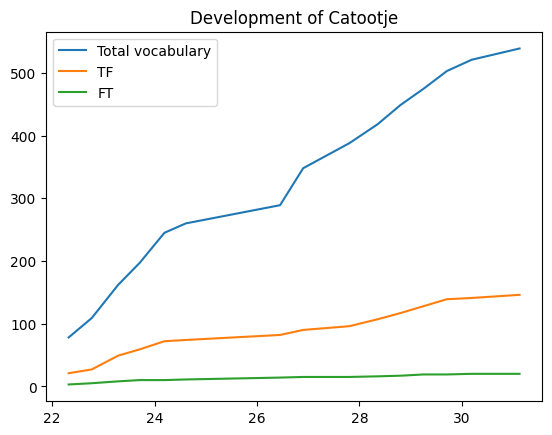

None


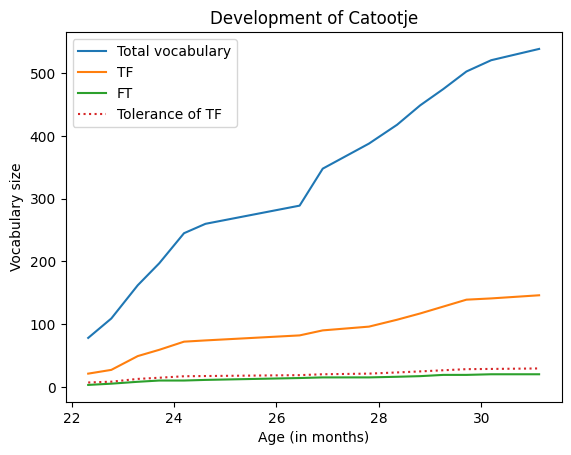

In [50]:
# Plot the vocabulary development of a specific child


child_test = build_wordlists_for_child(children_names_file[corpus_name][0], df)
#print(child_test.wordlists[0])
child_test.build_complete_wordlists(df)

if corpus_name not in ['Bracci', 'FoxBoyer', 'Penney', 'Kuwaiti']:
    print(child_test.plot_vocab_dev(['TF', 'FT']))
    #print(child_test.complete_wordlists)
    #print(child_test.complete_wordlists[0])

    child_test.plot_vocab_dev_tolerance({'TF': ['FT']})

In [51]:
# Investigate what word types occur how often

word_type_investigation()

TF        886
T         692
TFF       287
FT        104
FTF        95
TFFF       45
F          35
FFT        30
FFTF       18
TFTF       18
TTF        17
TT         14
FTFF        9
TFT         6
TFFFF       6
FFFT        5
FTFTF       4
FFTFF       4
TFFT        4
TFFTF       3
FF          2
FFFF        2
FFFTTF      1
TFTFF       1
TTFF        1
FFTFFF      1
FTFFFF      1
FFF         1
Name: representation, dtype: int64


In [52]:
# Run reproduction of tables
#children_names = ['Catootje', 'David', 'Elke', 'Enzo', 'Eva', 'Jarmo', 'Leon', 'Leonie', 'Noortje', 'Robin', 'Tirza', 'Tom']

run_reproduce_tables(df, children_names_file[corpus_name])

filtered_df = df[df.word.apply(lambda x: not (x[-1] == 'n' and x[-2] == 'e'))]
filtered_df = filtered_df[filtered_df.word.apply(lambda x: not (x[-1] == 'e' and x[-2] == 'j'))]
filtered_df = filtered_df[filtered_df.model.apply(lambda x: not ('ˌ' in x))]
run_reproduce_tables(filtered_df, children_names_file[corpus_name])



----- Table 1: Truncation -----
Catootje :
trochees: 5.360134003350084 (32/597)
iamben: 8.791208791208792 (8/91)
David :
trochees: 5.365853658536586 (11/205)
iamben: 18.51851851851852 (5/27)
Elke :
trochees: 11.28048780487805 (37/328)
iamben: 89.0909090909091 (49/55)
Enzo :
trochees: 8.130081300813007 (30/369)
iamben: 28.000000000000004 (14/50)
Eva :
trochees: 9.221902017291066 (32/347)
iamben: 77.77777777777779 (21/27)
Jarmo :
trochees: 11.837455830388691 (67/566)
iamben: 68.57142857142857 (24/35)
Leon :
trochees: 2.7491408934707904 (16/582)
iamben: 22.916666666666664 (22/96)
Leonie :
trochees: 7.87037037037037 (17/216)
iamben: 8.0 (2/25)
Noortje :
trochees: 8.847184986595174 (33/373)
iamben: 54.54545454545454 (24/44)
Robin :
trochees: 6.289308176100629 (40/636)
iamben: 33.33333333333333 (18/54)
Tirza :
trochees: 6.4833005893909625 (33/509)
iamben: 52.5 (21/40)
Tom :
trochees: 10.567514677103718 (54/511)
iamben: 43.42105263157895 (33/76)


----- Table 2: Stress errors -----
Catootje

In [53]:
def collect_trunc_bisyllables():
    print(df.rep_model.apply(lambda x: len(x) == 2))
    table_df = df[df.rep_model.apply(lambda x: len(x) == 2)]
    table_df = table_df[table_df.rep_realization.apply(lambda x: len(x) == 1)]
    write_df_to_csv('truncated_bisyllables.csv', table_df)
    print(table_df)

# Generally no need to do this every run of the notebook
#collect_trunc_bisyllables(children_names_file[corpus_name])


In [54]:
def is_final_syllable_heavy(word):
        if word[-1] in ipa_vowels:
            # if the last letter is a vowel, we only have a heavy syllable if it is a diphtong, so if the letter before it is also a vowel
            return word[-2] in ipa_vowels
        if word[-2] == 'ə':
            return False
        else: #so final letter in agnostic_symbols or consonants
            return True

def collect_heavy_trochees():
    table_df = df[df.rep_model.apply(lambda x: len(x) == 2)]
    table_df = table_df[table_df.model.apply(lambda x: is_final_syllable_heavy(x))]
    table_df = table_df[table_df.rep_model.apply(lambda x: not x[1])]
    #table_df = table_df[table_df.rep_realization.apply(lambda x: len(x) == 2)]
    #table_df = table_df[table_df.rep_realization.apply(lambda x: x[1])]
    print(table_df)
    write_df_to_csv('heavy_trochees_all.csv', table_df)
    #print(table_df)
    
collect_heavy_trochees()

       Name               Age       word       model realization  \
21     Leon  P1Y10M28DT0H0M0S   buikpijn  ˈbœykˌpɛin  ˈbœyχˌpɛin   
22     Leon  P1Y10M28DT0H0M0S   buikpijn  ˈbœykˌpɛin  ˈbœykˌpɛin   
63     Leon  P1Y10M28DT0H0M0S    inktvis   ˈɪŋktˌvɪs    ˈʔɪŋˌfɪs   
64     Leon  P1Y10M28DT0H0M0S    inktvis   ˈɪŋktˌvɪs  ˈʔɪŋṭˌfɪs   
66     Leon  P1Y10M28DT0H0M0S   juffrouw     ˈjœfʀɑu    ˈlʉfʀɑuw   
...     ...               ...        ...         ...         ...   
19569  Elke   P2Y3M26DT0H0M0S    ketting      ˈkɛtɪŋ      ˈkɪnit   
19570  Elke   P2Y3M26DT0H0M0S    ketting      ˈkɛtɪŋ      ˈkɪtin   
19623  Elke   P2Y3M26DT0H0M0S  schildpad   ˈsχɪlˌpɑt      ˈχɪpɑt   
19624  Elke   P2Y3M26DT0H0M0S  schildpad   ˈsχɪlˌpɑt   ˈχɪŭpɑt̠   
19625  Elke   P2Y3M26DT0H0M0S  schildpad   ˈsχɪlˌpɑt    ˈχɪˌpɑtʰ   

           rep_model rep_realization  
21     [True, False]   [True, False]  
22     [True, False]   [True, False]  
63     [True, False]   [True, False]  
64     [True, False]   [Tru

### Stages
- Stage 1: disyllables realized as monosyllabic
- Stage 2: both syllables realized, but stress on first syllable
- Stage 3: both syllables realized with equal stress
- Stage 4: adult like stress realization

{'TF': (array([32., 21., 43., 38., 49., 11., 18., 26., 13., 17., 18., 20., 20.,
        8., 15.]), {'FT': array([0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.])})}


/tmp/ipykernel_650357/3248814852.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


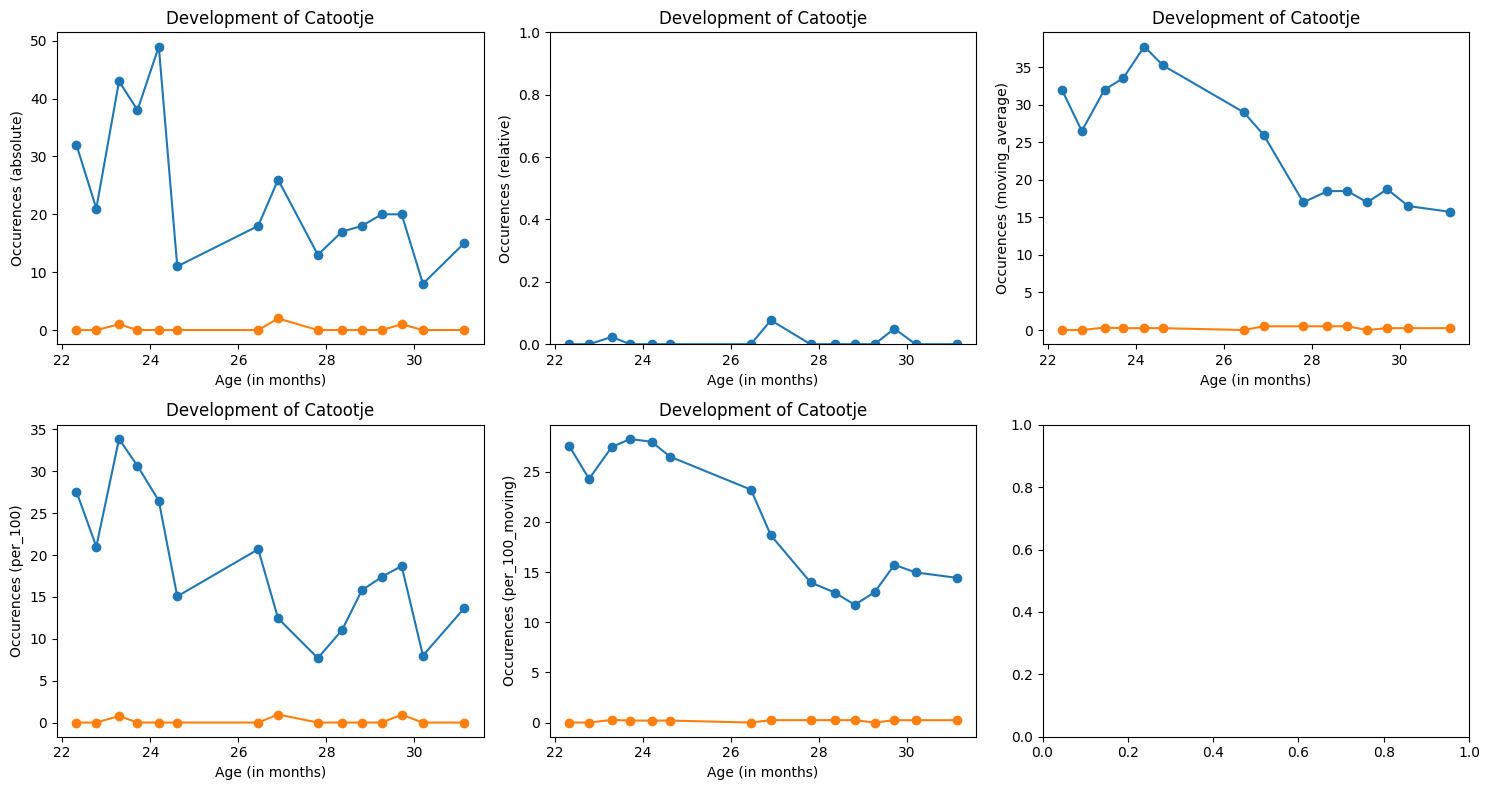

In [55]:
#iamb_bisyl_phases = ['T', 'T@', 'TF', 'TT', 'FT']
#patterns = {'FT': iamb_bisyl_phases}
counts = calc_phase_dev(child_test, analysis_dictionary['Fikkert']['patterns_heavy'])#['FT', 'FT', 'FT', 'FT', 'FT'], ['T', 'TF', 'TT', 'FT', 'AA'])
print(counts)


'''
# These plotting functions are no longer necessary, but still work
child_test.plot_count_patterns(counts, mode='absolute')
plt.show()
child_test.plot_count_patterns(counts, mode='relative')
plt.show()
child_test.plot_count_patterns(counts, mode='moving_average')
plt.show()
child_test.plot_count_patterns(counts, mode='per_100')
plt.show()
child_test.plot_count_patterns(counts, mode='per_100_moving')
plt.show()
'''

types = ['absolute', 'relative', 'moving_average', 'per_100', 'per_100_moving']
fig, axs = plt.subplots(int(math.ceil(len(types)/3)), 3, figsize=(15,8))
axs = axs.ravel()

for i,t in enumerate(types):
    axs[i] = child_test.plot_count_patterns(counts, mode=t, ax=axs[i])

fig.tight_layout()
fig.show()

# Loop through children and create development
This part of the code:
- Loops through the children of the current corpus
- Creates the developments of these children
- Creates the necessary plots for these children

/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarn

/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarn

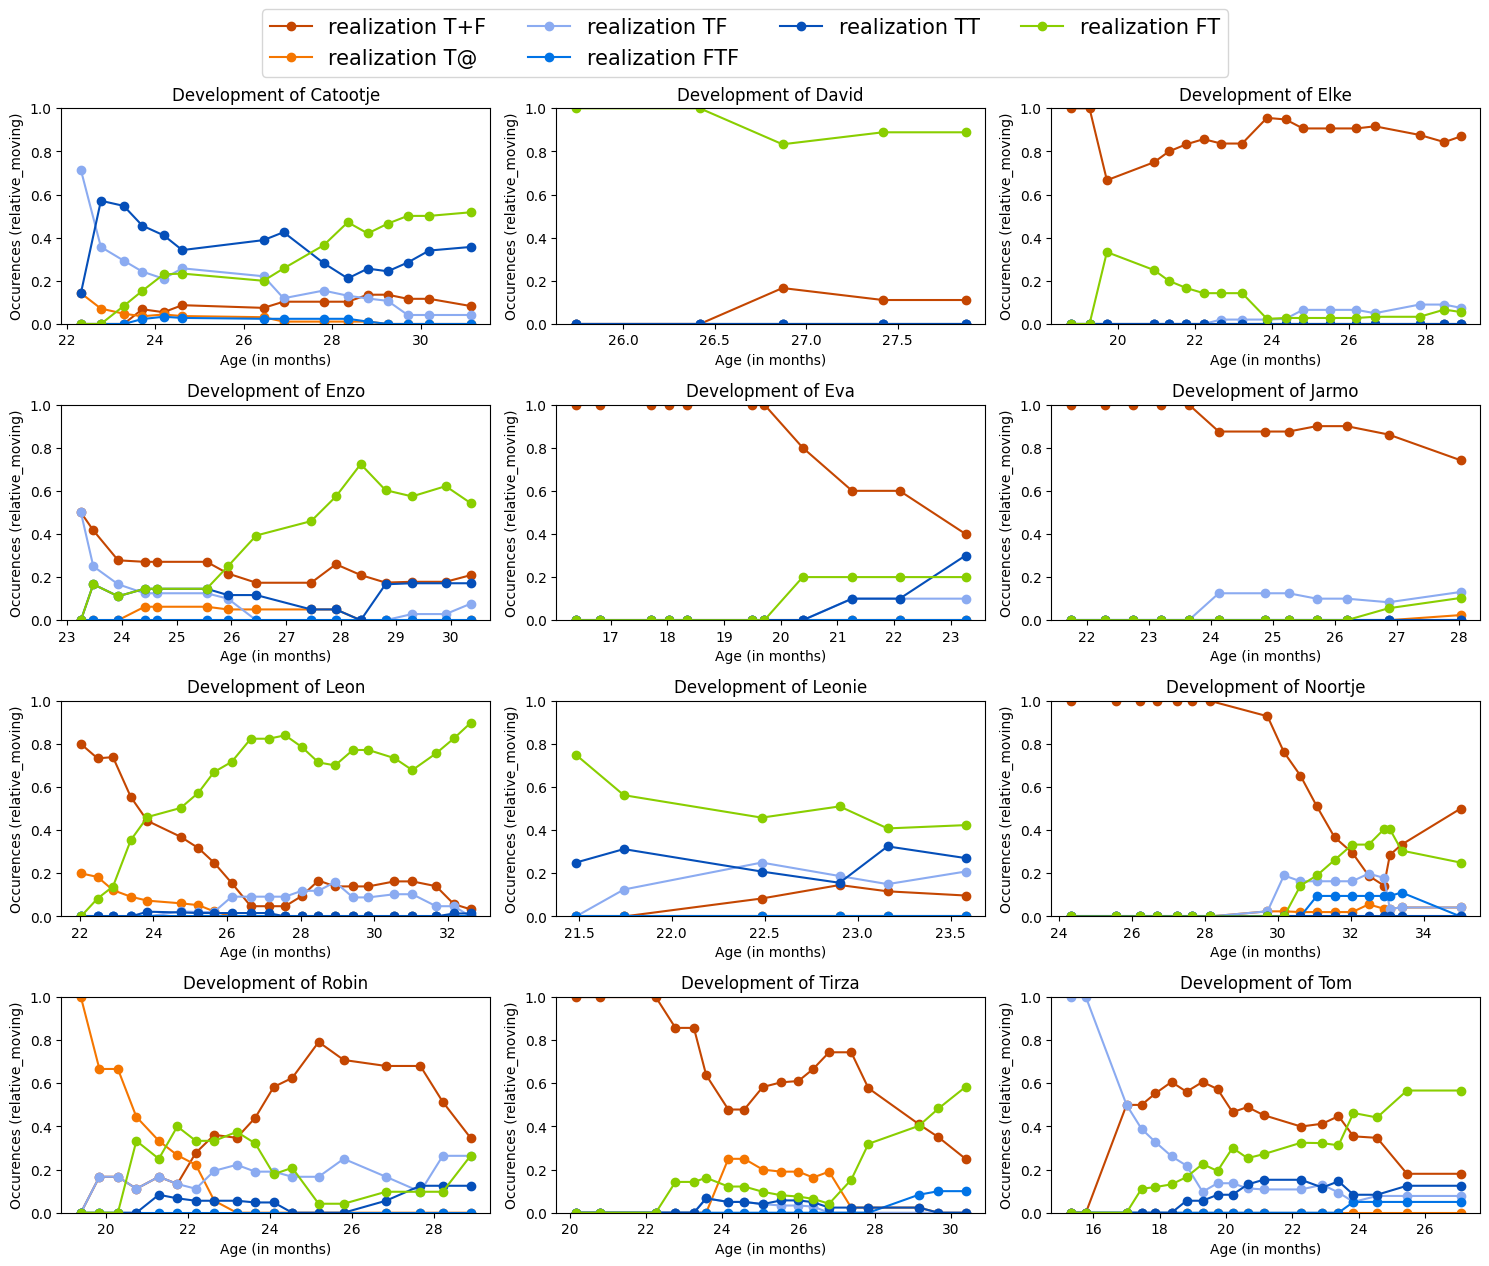

In [56]:
loop_through_children(df, children_names_file[corpus_name], analysis_dictionary['Fikkert'], colors=analysis_dictionary['Fikkert']['color_dict_patterns'], mode='relative_moving', window_size = 7)


/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarn

/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarn

ValueError: too many values to unpack (expected 2)

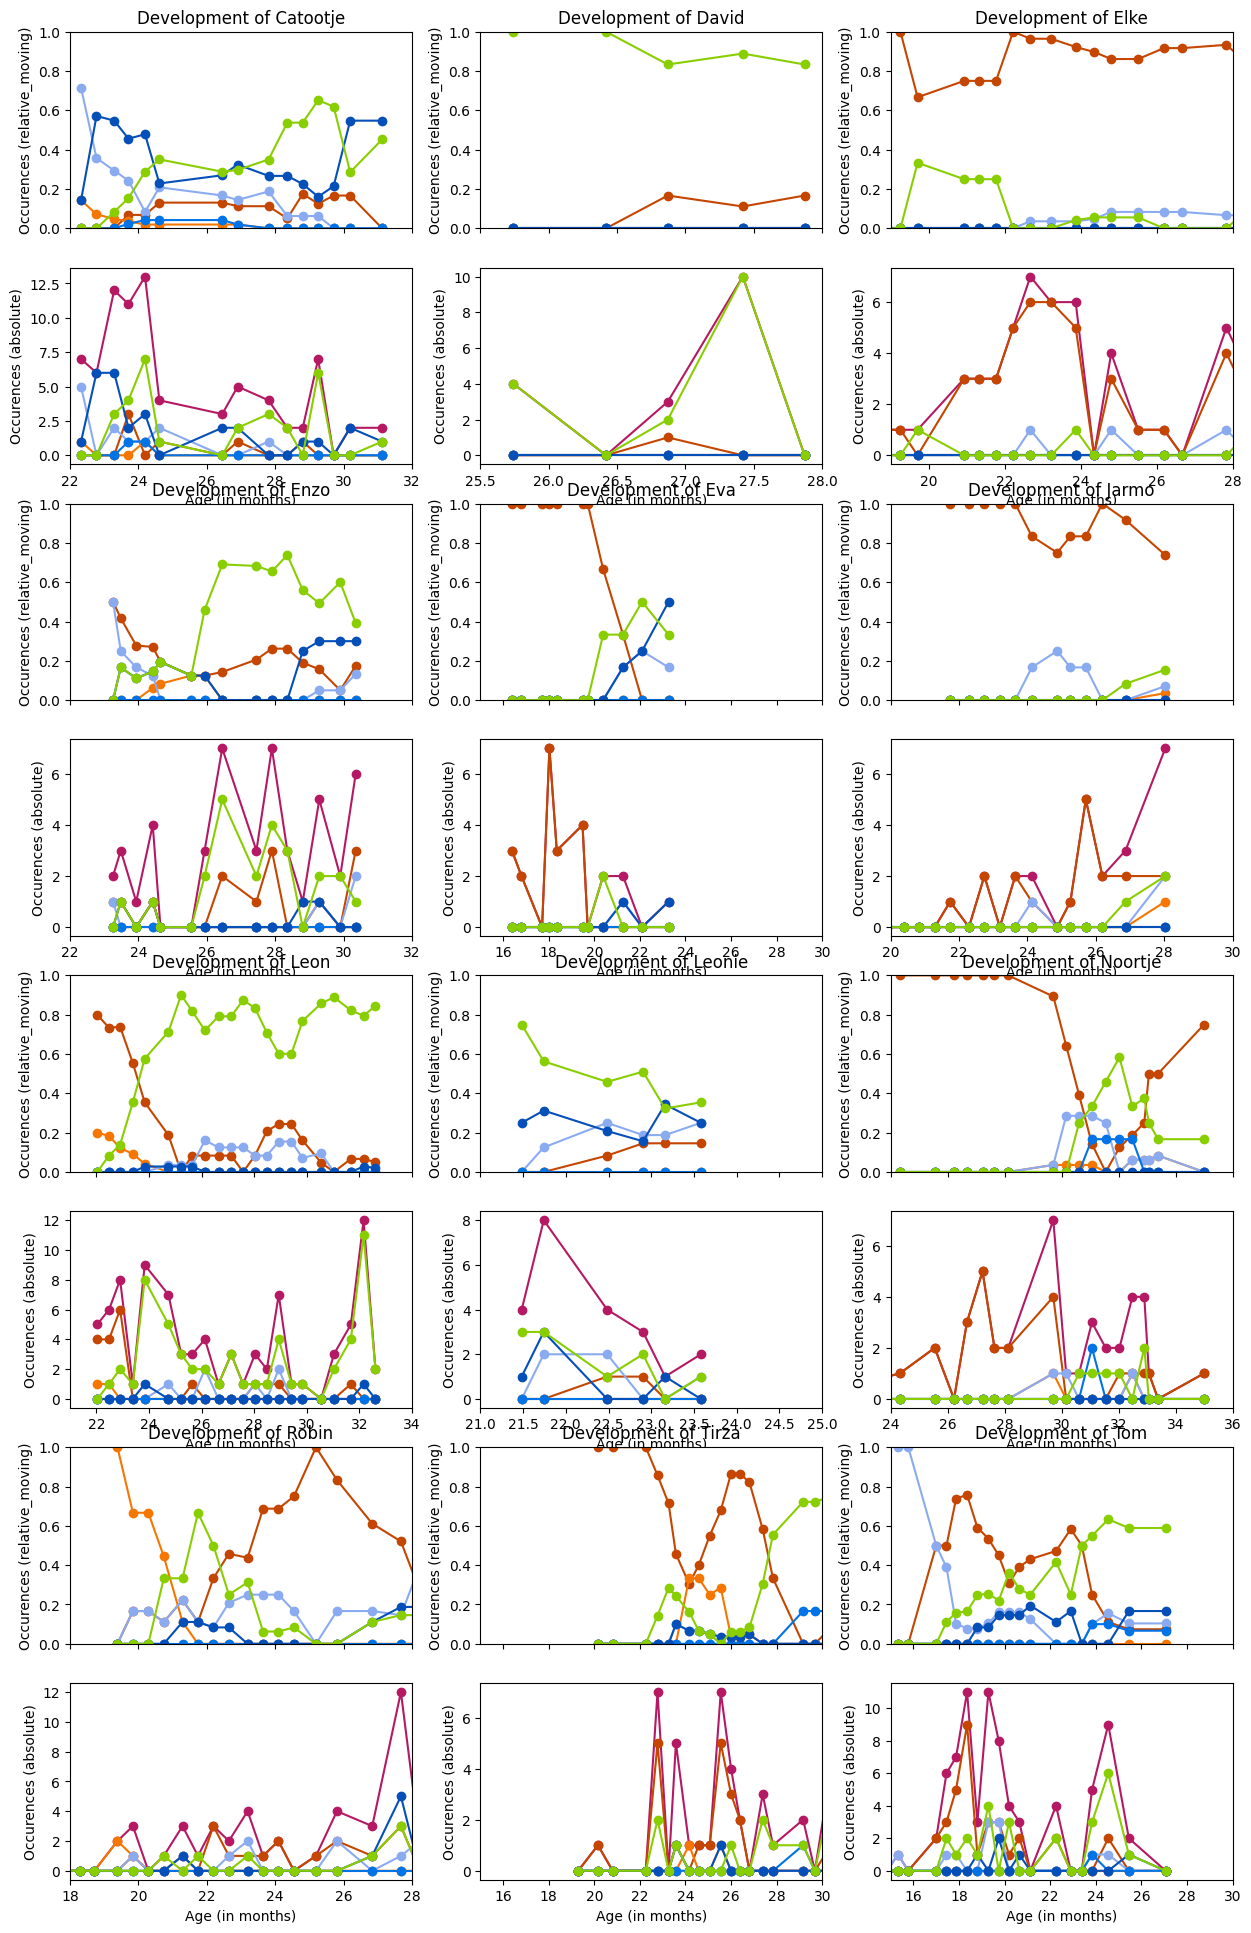

In [66]:
if corpus_name == 'Providence':
    loop_through_children_two_modes(children_names_file[corpus_name], analysis_dictionary['Fikkert'], nr_per_row=3, xlim=xlim_per_child_dict[corpus_name], mode1='relative_moving', mode2='absolute', colors=analysis_dictionary['Fikkert']['color_dict_patterns'], window_size = 10)
else: 
    loop_through_children_two_modes(children_names_file[corpus_name], analysis_dictionary['Fikkert'], nr_per_row=3, xlim=xlim_per_child_dict[corpus_name], mode1='relative_moving', mode2='absolute', colors=analysis_dictionary['Fikkert']['color_dict_patterns'])


/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarn

/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/4166565603.py:344: RuntimeWarning: invalid value encountered in true_divide
  df_count_rp = pd.DataFrame(counts[p][1][rp]/counts[p][0])
/tmp/ipykernel_650357/497405128.py:12: RuntimeWarnin

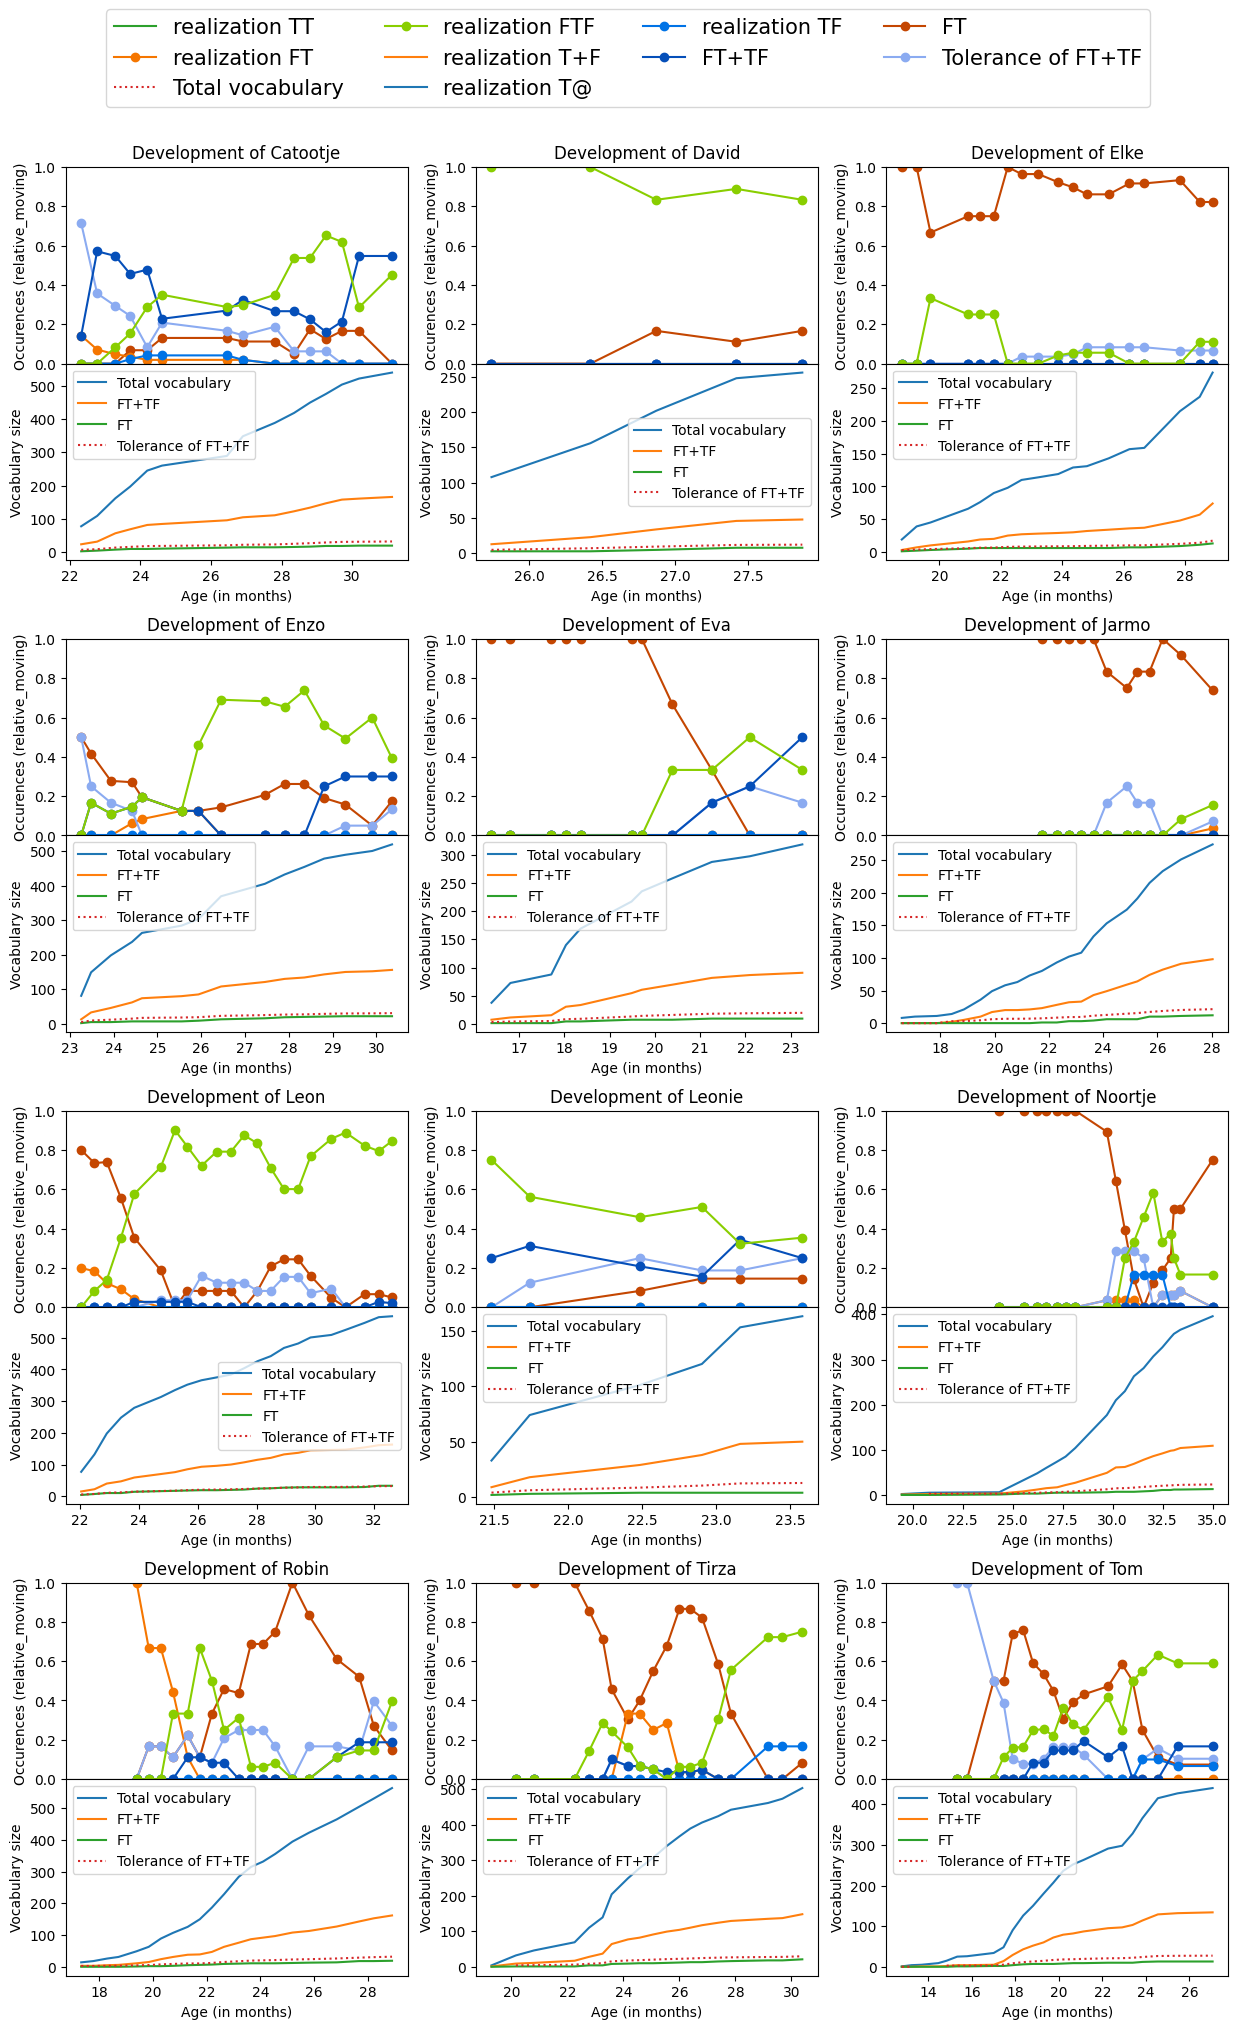

In [62]:
loop_through_children_two_modes(children_names_file[corpus_name], analysis_dictionary['Fikkert'], mode1='relative_moving', mode2='tolerance', colors=analysis_dictionary['Fikkert']['color_dict_patterns'])


## Word level development

In [ ]:
plot_per_word(df, 'konijn', children_names_file[corpus_name], analysis_dictionary['Fikkert'], colors=analysis_dictionary['Fikkert']['color_dict_patterns'], mode='relative')


In [ ]:
plot_per_word(df, 'konijn', [None], analysis_dictionary['Fikkert'], colors=analysis_dictionary['Fikkert']['color_dict_patterns'], mode='relative_moving', single_plot=True)


In [ ]:
for child_name in wordlevel_child_names[corpus_name]:
    loop_through_words_for_child(df, child_name, analysis_dictionary['Fikkert']['patterns'], words_per_child_dict[corpus_name][child_name], nr_per_row=2, xlim=xlim_per_child_dict[corpus_name][child_name], mode='relative', colors=analysis_dictionary['Fikkert']['color_dict_patterns'])



# Iamb graphs

In [ ]:
def loop_through_children_iamb_graphs(children_names, analysis, nr_per_row = 3):
    
    # Create graph stuff
    plot_height = nr_per_row*int(math.ceil(len(children_names)/nr_per_row))*2
    fig, axs = plt.subplots(2*(int(math.ceil(len(children_names)/nr_per_row))), nr_per_row, figsize=(15,plot_height))
    axs = axs.ravel()
    
    for i, child_name in enumerate(children_names):
        child_test = build_wordlists_for_child(child_name, df)
        child_test.build_complete_wordlists(df) 
        counts_overgen_iamb = calc_phase_dev(child_test, analysis['overgen_iamb'])
        counts_patterns_heavy = calc_phase_dev(child_test, analysis['patterns_heavy'])
        
        loc_graph = 2*i - (i%nr_per_row)
        #print(loc_graph)
        axs[loc_graph] = child_test.plot_count_patterns(counts_overgen_iamb, mode='absolute', ax=axs[loc_graph])
        axs[loc_graph + nr_per_row] = child_test.plot_count_patterns(counts_patterns_heavy, mode='absolute', ax=axs[loc_graph+nr_per_row])

    fig.tight_layout()
    fig.show()

loop_through_children_iamb_graphs(children_names_file[corpus_name], analysis_dictionary['Fikkert'])


In [ ]:
loop_through_children_two_modes(children_names_file[corpus_name], analysis_dictionary['Fikkert'], mode2='tolerance')


In [ ]:
#loop_through_children_two_modes([None], analysis_dictionary['Fikkert'], nr_per_row = 1, mode1='relative_moving', mode2='absolute', single_plot=True)
loop_through_children(df, [None], analysis_dictionary['Fikkert'], nr_per_row = 1, mode='relative_moving', single_plot=True, colors=analysis_dictionary['Fikkert']['color_dict_patterns'], window_size=50)


In [ ]:
find_common_words(df, condition='Th')

## Analyses based on Kehoe (1998)

Model pattern: TFT (SWS in paper)

Possible realizations (p. 12): T, TF, level stress (TT, TTT, FF, FFF), FT

Kehoe also talks about non-truncated forms with initial main stress (instead of final main stress), but script does not distinguish between those. 

NB: looking at the data, it seems that the CLPF data set is unsuited to test this paper, as almost all TFT occurrences are samenstellingen except for one occurrence of 'krokodil'

In [ ]:
loop_through_children_two_modes(children_names_file[corpus_name], analysis_dictionary['Kehoe_SWS'], mode2='tolerance')


In [ ]:
plot_per_word(df, 'krokodil', children_names_file[corpus_name], analysis=analysis_dictionary['Kehoe_SWS']['patterns'], mode='relative_moving')


# Dummy graph
Graph to show what we would expect in an ideal situation

In [ ]:
val_dict = {
    'T+F' : [0, 3, 7, 7, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'T@' : [0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    'TF' : [0, 0, 0, 1, 5, 5, 8, 5, 1, 0, 0, 0, 0, 0, 0, 0],
    'FTF' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'TT' : [0, 0, 0, 0, 0, 0, 0, 1, 5, 8, 5, 1, 0, 0, 0, 0],  
    'FT' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 8, 8, 8, 8]
}

val_dict_rel = {}
totals = np.ones(len(val_dict['T+F']))
for key in val_dict.keys():
    totals += val_dict[key]
print(totals)

for key in val_dict.keys():
    plt.plot(np.arange(20,36), val_dict[key]/totals, label="realization {}".format(key), c=analysis_dictionary['Fikkert']['color_dict_patterns']['r'+ key])
phase_boundaries = [24, 27.5, 30.5]
for b in phase_boundaries:
    plt.axvline(x=b, color='black', linestyle='--')
plt.legend()

In [ ]:
t= np.arange(1000)/100.
x = np.sin(2*np.pi*10*t)
y = np.cos(2*np.pi*10*t)

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(t,x)
ax2.plot(t,y)

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax2.autoscale()

plt.show()

# Todo

- Foxboyer and Bracci do not build word lists, probably because they are crosssectional instead of longitudinal corpora; maybe fix so that they build at least one wordlist for the one meassuring moment


## Notes
- Stuttgart corpus does not include model IPA
- Zink corpus is on the brabbel period and therefore does not contain much word information
- Utrecht corpus is of children with language problems and has a lot of missing IPA transcriptions